# Sunspot

## Data description:
Monthly mean total sunspot number obtained by taking a simple arithmetic mean of the daily total sunspot number over all days of each calendar month. Monthly means are available only since 1749 because the original observations compiled by Rudolph Wolf were too sparse before that year. (Only yearly means are available back to 1700)
A value of -1 indicates that no number is available (missing value).

Filename: SN_m_tot_V2.0.csv
Format: Comma Separated values (adapted for import in spreadsheets)
The separator is the semicolon ';'.

Contents:
- Column 1-2: Gregorian calendar date
    - Year
    - Month
- Column 3: Date in fraction of year.
- Column 4: Monthly mean total sunspot number.
- Column 5: Monthly mean standard deviation of the input sunspot numbers.
- Column 6: Number of observations used to compute the monthly mean total sunspot number.
- Column 7: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional.

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.special import gamma

We want to see  Here only column 3 and 4 are relevent to us.

In [2]:
df_sunspot = pd.read_csv("SN_m_tot_V2.0.csv")

years = np.array(df_sunspot["C3"])  # fraction of year.
sunspot_count = np.array(df_sunspot["C4"])  # sunspot count.

Text(0.5, 1.0, 'Sunspot (1970-2024')

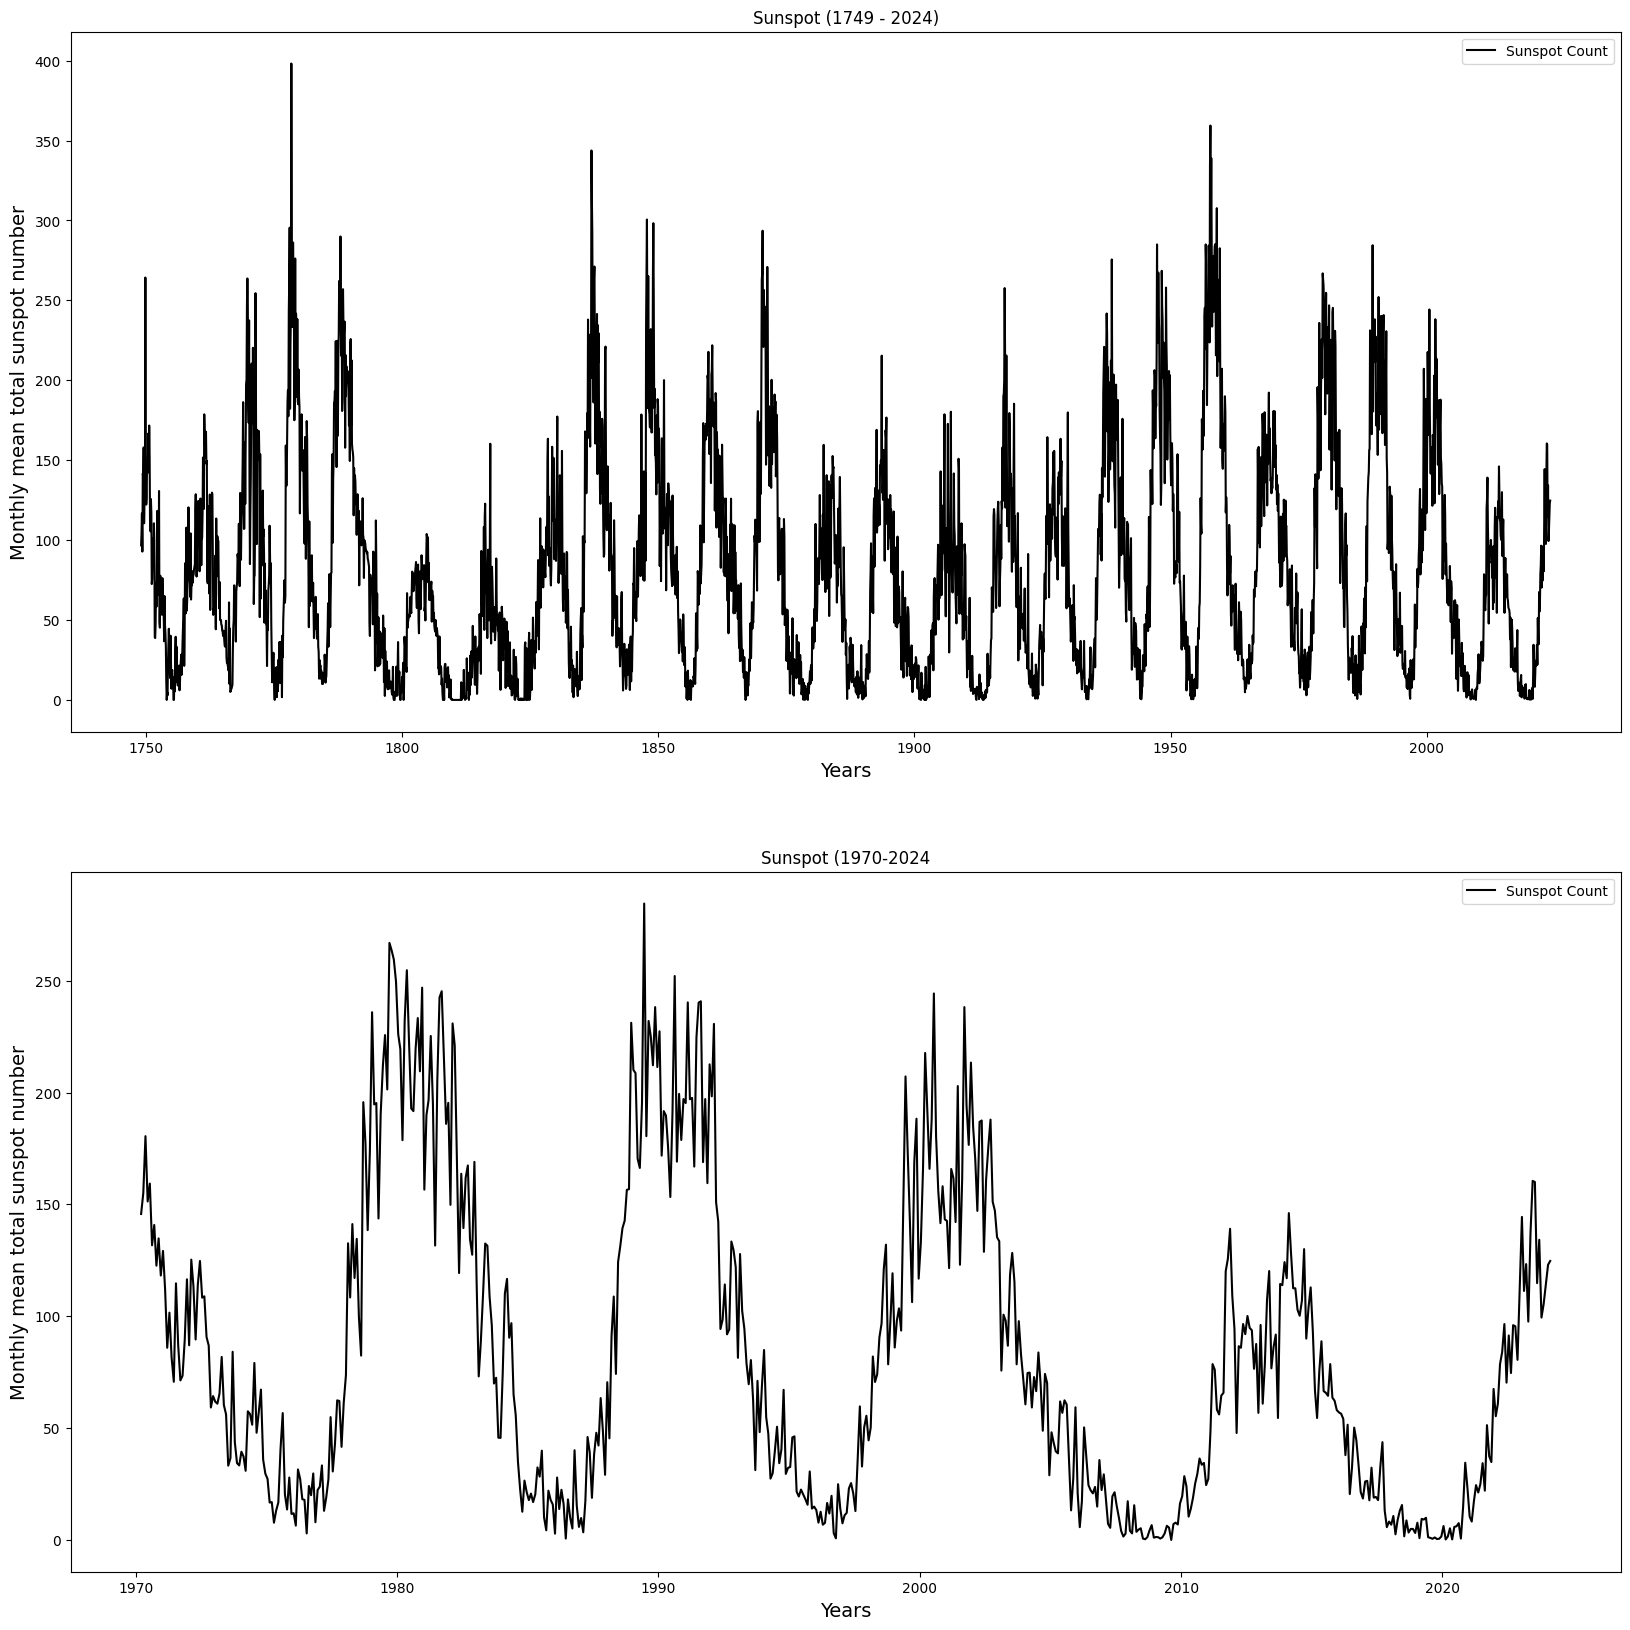

In [3]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
sns.lineplot(x=years, y=sunspot_count, color="k", label="Sunspot Count")
plt.xlabel("Years", fontsize=14)
plt.ylabel("Monthly mean total sunspot number", fontsize=14)
plt.title("Sunspot (1749 - 2024)")

plt.subplot(2, 1, 2)
sns.lineplot(x=years[2654:], y=sunspot_count[2654:], color="k", label="Sunspot Count")
plt.xlabel("Years", fontsize=14)
plt.ylabel("Monthly mean total sunspot number", fontsize=14)
plt.title("Sunspot (1970-2024")

## plot the histogram of sunspot.

Text(0.5, 1.0, 'Frequency of Sunspot (1749-2024)')

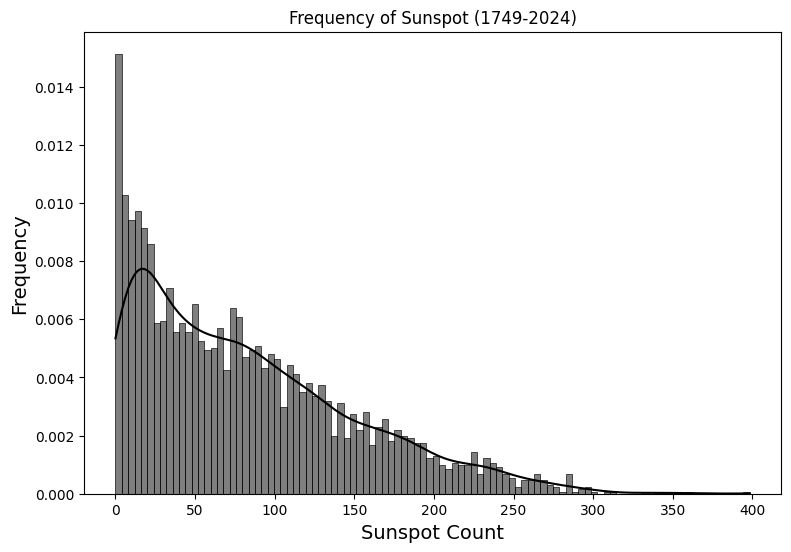

In [4]:
plt.figure(figsize=(9, 6))
sns.histplot(
    sunspot_count,
    color="black",
    stat="density",
    kde=True,
    bins=100,
    label="Sunsopt Count",
)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Sunspot Count", fontsize=14)
plt.title("Frequency of Sunspot (1749-2024)")

Here we can see that the frequency roughly follows Gamma distribution.

### PDF Gamma
Let $x\sim G(\alpha,\lambda)$ then,
$$
    f(x;\alpha,\lambda) = \frac{\lambda e^{-\lambda x} (\lambda x)^{\alpha -1} }{\Gamma(\alpha)}
$$

Here, we have to find $\alpha, \lambda$ so we use M-H algorithm to find those.

In [48]:
# prior density
def prior(alpha, lam):
    if alpha <= 0 or lam <= 0:
        return 0
    else:
        return 1


#log Likelihood
def log_like_gamma(alpha, lam, data):
    return np.sum(
        np.log(lam)
        - (lam * data)
        + (alpha - 1) * np.log(lam * data)
        - np.log(gamma(alpha))
    )
# def log_like_gamma(alpha, lam, data):
#     return np.sum(np.log(scipy.stats.gamma(alpha,lam).pdf(data)))


# accept
def acceptance(current, new):
    if new > current:
        return True
    else:
        accept = np.random.uniform(0, 1)
        # since we are dealing with log of likelihood function so we have to take exp.
        return accept < (np.exp(new - current))


# M-H
def Metropolis(
    init_state,
    data,
    log_like_gamma=log_like_gamma,
    prior=prior,
    acceptance=acceptance,
    sample_size=50000,
):
    alpha_currnet_state = init_state[0]
    lam_currnet_state = init_state[1]
    accpet_alpha = []
    reject_alpha = []
    accept_lam = []
    reject_lam = []
    for _ in range(sample_size):
        alpha_candidate_state = np.random.normal(alpha_currnet_state, 0.05)
        lam_candidate_state = np.random.normal(lam_currnet_state, 1)

        current_likelihooh = log_like_gamma(
            alpha_currnet_state, lam_currnet_state, data
        )
        candidate_likelihood = log_like_gamma(
            alpha_candidate_state, lam_candidate_state, data
        )

        if acceptance(
            current_likelihooh + np.log(prior(alpha_currnet_state, lam_currnet_state)),
            candidate_likelihood
            + np.log(prior(alpha_candidate_state, lam_candidate_state)),
        ):
            alpha_currnet_state = alpha_candidate_state
            lam_currnet_state = lam_candidate_state
            accpet_alpha.append(alpha_currnet_state)
            accept_lam.append(lam_currnet_state)
        else:
            reject_alpha.append(alpha_candidate_state)
            reject_lam.append(lam_candidate_state)

    return (
        np.array(accpet_alpha),
        np.array(reject_alpha),
        np.array(accept_lam),
        np.array(reject_lam),
    )

In [49]:
np.random.seed(1)

accept_alpha, reject_alpha, accept_lam, reject_lam = Metropolis(
    init_state=[4, 10], data=sunspot_count, sample_size=1_000_000
)

/tmp/ipykernel_131440/4204122274.py:14: RuntimeWarning: divide by zero encountered in log
  + (alpha - 1) * np.log(lam * data)
/tmp/ipykernel_131440/4204122274.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  return accept < (np.exp(new - current))


In [50]:
accept_alpha.shape

(0,)